In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


## Installations

In [2]:
# !pip install scikeras

## Imports

In [1]:
# all imports here

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor


from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score
from sklearn.metrics import classification_report,confusion_matrix

## 1. Loading the data

In [2]:
ROOT_DIR = os.path.dirname(os.path.dirname(os.path.abspath("RealEstate_Price_Prediction.ipynb")))

data_path = os.path.join(ROOT_DIR, "data\Property_with_Feature_Engineering.csv")
model_path = os.path.join(ROOT_DIR, "model")

property_data_fe = pd.read_csv(data_path)

In [3]:
property_data_fe.head()

,property_id,location_id,page_url,property_type,price,price_bin,location,city,province_name,locality,...,area_marla,area_sqft,purpose,bedrooms,date_added,year,month,day,agency,agent
0,347795,8,https://www.zameen.com/Property/lahore_model_t...,House,220000000,Very High,Model Town,Lahore,Punjab,"Model Town, Lahore, Punjab",...,120.0,32670.12,For Sale,0,07-17-2019,2019,7,17,Real Biz International,Usama Khan
1,482892,48,https://www.zameen.com/Property/lahore_multan_...,House,40000000,Very High,Multan Road,Lahore,Punjab,"Multan Road, Lahore, Punjab",...,20.0,5445.02,For Sale,5,10-06-2018,2018,10,6,Khan Estate,mohsinkhan and B
2,555962,75,https://www.zameen.com/Property/eden_eden_aven...,House,9500000,Low,Eden,Lahore,Punjab,"Eden, Lahore, Punjab",...,9.0,2450.26,For Sale,3,07-03-2019,2019,7,3,Shahum Estate 2,"Babar Hameed, Raja Omar"
3,562843,3821,https://www.zameen.com/Property/gulberg_2_gulb...,House,125000000,Very High,Gulberg,Lahore,Punjab,"Gulberg, Lahore, Punjab",...,20.0,5445.02,For Sale,8,04-04-2019,2019,4,4,NaN,NaN
4,686990,3522,https://www.zameen.com/Property/allama_iqbal_t...,House,21000000,High,Allama Iqbal Town,Lahore,Punjab,"Allama Iqbal Town, Lahore, Punjab",...,11.0,2994.76,For Sale,6,04-04-2019,2019,4,4,NaN,NaN


## 2. Checking out data description and necessary information

In [4]:
property_data_fe.columns

Index(['property_id', 'location_id', 'page_url', 'property_type', 'price',
       'price_bin', 'location', 'city', 'province_name', 'locality',
       'latitude', 'longitude', 'baths', 'area', 'area_marla', 'area_sqft',
       'purpose', 'bedrooms', 'date_added', 'year', 'month', 'day', 'agency',
       'agent'],
      dtype='object')

### i. Finding out fields' datatypes

In [5]:
property_data_fe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191393 entries, 0 to 191392
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   property_id    191393 non-null  int64  
 1   location_id    191393 non-null  int64  
 2   page_url       191393 non-null  object 
 3   property_type  191393 non-null  object 
 4   price          191393 non-null  int64  
 5   price_bin      191393 non-null  object 
 6   location       191393 non-null  object 
 7   city           191393 non-null  object 
 8   province_name  191393 non-null  object 
 9   locality       191393 non-null  object 
 10  latitude       191393 non-null  float64
 11  longitude      191393 non-null  float64
 12  baths          191393 non-null  int64  
 13  area           191393 non-null  object 
 14  area_marla     191393 non-null  float64
 15  area_sqft      191393 non-null  float64
 16  purpose        191393 non-null  object 
 17  bedrooms       191393 non-nul

### ii. Finding out statistical summary

In [6]:
property_data_fe.describe()

,property_id,location_id,price,latitude,longitude,baths,area_marla,area_sqft,bedrooms,year,month,day
count,1.913930e+05,191393.000000,1.913930e+05,191393.000000,191393.000000,191393.000000,191393.000000,1.913930e+05,191393.000000,191393.000000,191393.000000,191393.000000
mean,1.573170e+07,4224.580350,1.644655e+07,30.104593,71.572992,2.865956,14.573527,3.967656e+03,3.171516,2018.935687,6.212270,13.349631
std,2.215249e+06,3719.125201,3.416412e+07,3.645941,3.080463,2.435332,443.343252,1.207006e+05,1.952403,0.245310,1.815174,8.486820
min,8.657500e+04,1.000000,0.000000e+00,11.052446,25.906027,0.000000,0.000000,0.000000e+00,0.000000,2018.000000,1.000000,1.000000
25%,1.511867e+07,1057.000000,8.000000e+04,24.972287,67.152597,0.000000,4.900000,1.334030e+03,2.000000,2019.000000,6.000000,5.000000
50%,1.676385e+07,3233.000000,7.300000e+06,31.463563,73.077743,3.000000,7.600000,2.069110e+03,3.000000,2019.000000,7.000000,14.000000
75%,1.715282e+07,7182.000000,1.800000e+07,33.550869,74.228218,4.000000,12.000000,3.267010e+03,4.000000,2019.000000,7.000000,20.000000
max,1.769386e+07,14246.000000,2.000000e+09,73.184088,80.161430,403.000000,124444.000000,3.388000e+07,68.000000,2019.000000,12.000000,30.000000


### iii. Finding out duplicates and nulls (if any)

In [7]:
property_data_fe.duplicated().sum()

0

In [8]:
property_data_fe.isnull().sum()

property_id          0
location_id          0
page_url             0
property_type        0
price                0
price_bin            0
location             0
city                 0
province_name        0
locality             0
latitude             0
longitude            0
baths                0
area                 0
area_marla           0
area_sqft            0
purpose              0
bedrooms             0
date_added           0
year                 0
month                0
day                  0
agency           47379
agent            47380
dtype: int64

Already we are not going to need the agency and agent fields, so no need to alter them.

### iv. Checking the values

In [9]:
property_data_fe["bedrooms"].unique()

array([ 0,  5,  3,  8,  6,  4,  2,  7,  1, 10, 11,  9, 12, 14, 15, 16, 13,
       18, 28, 25, 21, 68, 27, 20], dtype=int64)

In [10]:
property_data_fe["baths"].unique()

array([  0,   5,   7,   6,   4,   3,   2,   8,   1,  10,   9,  11,  13,
        12, 403,  14,  15], dtype=int64)

We know that having no bedroom and/ or no bathroom is not possible, so it can be a typo. We need to get rid of those rows!

In [11]:
property_data_fe[property_data_fe["baths"] > property_data_fe["bedrooms"]].count()

property_id      40384
location_id      40384
page_url         40384
property_type    40384
price            40384
price_bin        40384
location         40384
city             40384
province_name    40384
locality         40384
latitude         40384
longitude        40384
baths            40384
area             40384
area_marla       40384
area_sqft        40384
purpose          40384
bedrooms         40384
date_added       40384
year             40384
month            40384
day              40384
agency           29391
agent            29391
dtype: int64

Woah! About 40,384 property records where each has # bathrooms more than # bedrooms! Even after this, we need to add 2 more rooms along with bedroom to check # bathrooms is still more than total rooms i.e., Bedroom + Dine, Dinning

In [12]:
property_data_fe[property_data_fe["baths"] > property_data_fe["bedrooms"] + 2].count()

property_id      755
location_id      755
page_url         755
property_type    755
price            755
price_bin        755
location         755
city             755
province_name    755
locality         755
latitude         755
longitude        755
baths            755
area             755
area_marla       755
area_sqft        755
purpose          755
bedrooms         755
date_added       755
year             755
month            755
day              755
agency           383
agent            383
dtype: int64

That's a relief!

In [13]:
property_data_fe["purpose"].unique()

array(['For Sale', 'For Rent'], dtype=object)

In [14]:
property_data_fe["property_type"].unique()

array(['House', 'Flat', 'Lower Portion', 'Penthouse', 'Upper Portion',
       'Farm House', 'Room'], dtype=object)

For the time being, we are only interested in Houses and flats. So, other proprty types will not be needed.

In [15]:
property_data_fe["city"].unique()

array(['Lahore', 'Karachi', 'Islamabad', 'Faisalabad', 'Rawalpindi'],
      dtype=object)

We only need selected areas whereas the data contain these locations:

In [16]:
property_data_fe["location"].unique()

array(['Model Town', 'Multan Road', 'Eden', ..., 'Shabbir Town',
       'Angori Scheme 1', 'Abid Road'], dtype=object)

In [17]:
property_data_fe[property_data_fe["city"] == "Karachi"].shape

(60484, 24)

## 3. Cleaning the data

### i. Dropping unnecessary rows

Where there is no bathroom or no bedroom!




In [18]:
property_data_fe.drop(property_data_fe[(property_data_fe['bedrooms']==0) | (property_data_fe['baths']==0)].index, inplace=True)

Where # bathrooms is more than # bedrooms + dine, dinning.

In [19]:
property_data_fe.drop(property_data_fe[property_data_fe["baths"] > property_data_fe["bedrooms"] + 2].index, inplace=True)

Where property type is other than House and Flats.



In [20]:
unnecessary_property_types = ['Lower Portion', 'Penthouse', 'Upper Portion','Farm House', 'Room']
property_data_fe.drop(property_data_fe[property_data_fe["property_type"].isin(unnecessary_property_types)].index, inplace=True)

Where city is Karachi.

In [21]:
excluded_cities = ['Lahore', 'Islamabad', 'Faisalabad', 'Rawalpindi']
property_data_fe.drop(property_data_fe[property_data_fe["city"].isin(excluded_cities)].index, inplace=True)

Where location is in ['Clifton', 'DHA Defence', 'Gadap Town', 'Gulistan-e-Jauhar', 'Gulshan-e-Iqbal', 'Gulshan-e-Iqbal Town',
             'Malir Cantonment', 'North Nazimabad', 'Scheme 33', 'DHA City Karachi', 'Faisal Cantonment', 'Federal B Area',
            'Gulshan-e-Maymar', 'KDA Scheme 1', 'Korangi', 'Naya Nazimabad', 'Nazimababd', 'North Karachi', 'PECHS',
             'Surjani Town']

In [22]:
locations = ['Clifton', 'DHA Defence', 'Gadap Town', 'Gulistan-e-Jauhar', 'Gulshan-e-Iqbal', 'Gulshan-e-Iqbal Town',
             'Malir Cantonment', 'North Nazimabad', 'Scheme 33', 'DHA City Karachi', 'Faisal Cantonment', 'Federal B Area',
            'Gulshan-e-Maymar', 'KDA Scheme 1', 'Korangi', 'Naya Nazimabad', 'Nazimababd', 'North Karachi', 'PECHS',
             'Surjani Town']

mask = property_data_fe["location"].isin(locations)
print(property_data_fe[mask]["location"].unique())

['Gulistan-e-Jauhar' 'DHA Defence' 'Gadap Town' 'Gulshan-e-Iqbal Town'
 'Scheme 33' 'North Nazimabad' 'Clifton' 'North Karachi' 'Federal B Area'
 'Korangi' 'Naya Nazimabad' 'KDA Scheme 1' 'DHA City Karachi']


In [23]:
property_data_fe.drop(property_data_fe[~property_data_fe["location"].isin(locations)].index, inplace=True)

### ii. Dropping unnecessary columns or fields

We do consider the most important features for price prediction and thus ignore other features in the dataset.

In [24]:
excess_columns = ['property_id', 'location_id', 'page_url', 'province_name', 'locality',
                  'latitude', 'longitude', 'area', 'area_marla','purpose', 'date_added',
                  'day', 'agency', 'agent']

property_data_fe = property_data_fe.drop(excess_columns, axis=1)

In [25]:
property_data_fe.columns

Index(['property_type', 'price', 'price_bin', 'location', 'city', 'baths',
       'area_sqft', 'bedrooms', 'year', 'month'],
      dtype='object')

### iii. Converting datatypes

Year and month fields should be qualitative and not quantitative, so converting them into string from int datatype.
Note: object by default

In [26]:
property_data_fe[['year', 'month']] = property_data_fe[['year', 'month']].astype('str')

### iv. Getting subset

In [27]:
property_subset = property_data_fe[(property_data_fe['year'] == '2019') & (property_data_fe['month'] == '7')]

### iv. Viewing the cleaned sample

In [28]:
property_subset.head()

,property_type,price,price_bin,location,city,baths,area_sqft,bedrooms,year,month
218,House,35000000,Very High,Gulistan-e-Jauhar,Karachi,8,4356.02,6,2019,7
221,House,13000000,Medium,Gadap Town,Karachi,4,2613.61,4,2019,7
257,House,91500000,Very High,DHA Defence,Karachi,6,6534.02,5,2019,7
281,Flat,22500000,Very High,DHA Defence,Karachi,3,2178.01,3,2019,7
282,House,45000000,Very High,Gulistan-e-Jauhar,Karachi,4,2885.86,4,2019,7


### v. Resetting the dataframe on the basis of indices and not any column/field

In [29]:
property_subset = property_subset.reset_index()
property_subset = property_subset.drop("index",axis=1)
property_subset.head()

,property_type,price,price_bin,location,city,baths,area_sqft,bedrooms,year,month
0,House,35000000,Very High,Gulistan-e-Jauhar,Karachi,8,4356.02,6,2019,7
1,House,13000000,Medium,Gadap Town,Karachi,4,2613.61,4,2019,7
2,House,91500000,Very High,DHA Defence,Karachi,6,6534.02,5,2019,7
3,Flat,22500000,Very High,DHA Defence,Karachi,3,2178.01,3,2019,7
4,House,45000000,Very High,Gulistan-e-Jauhar,Karachi,4,2885.86,4,2019,7


## Normality Test

In [30]:
property_subset['price_per_sqft'] = property_subset['price'] / property_subset['area_sqft']
property_subset.head()

,property_type,price,price_bin,location,city,baths,area_sqft,bedrooms,year,month,price_per_sqft
0,House,35000000,Very High,Gulistan-e-Jauhar,Karachi,8,4356.02,6,2019,7,8034.857508
1,House,13000000,Medium,Gadap Town,Karachi,4,2613.61,4,2019,7,4973.963216
2,House,91500000,Very High,DHA Defence,Karachi,6,6534.02,5,2019,7,14003.630231
3,Flat,22500000,Very High,DHA Defence,Karachi,3,2178.01,3,2019,7,10330.531081
4,House,45000000,Very High,Gulistan-e-Jauhar,Karachi,4,2885.86,4,2019,7,15593.272023


### Visual Method: Create a Histogram:
Plotting a histogram can provide a visual indication of whether the data follows a normal distribution. If the histogram is roughly bell-shaped, then the data is assumed to be normally distributed

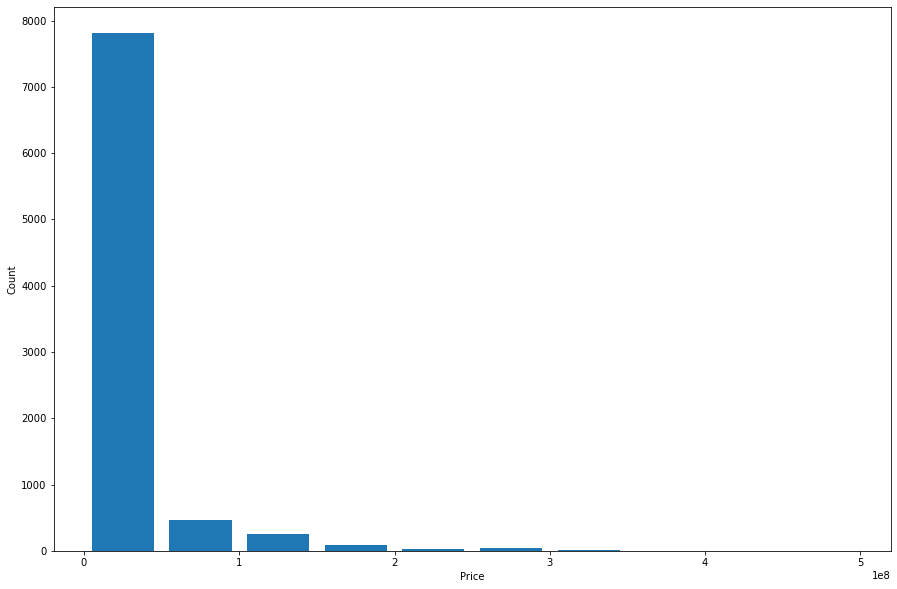

In [31]:
fig, ax = plt.subplots(figsize=(15,10))
plt.hist(property_subset['price'], rwidth=0.8)
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

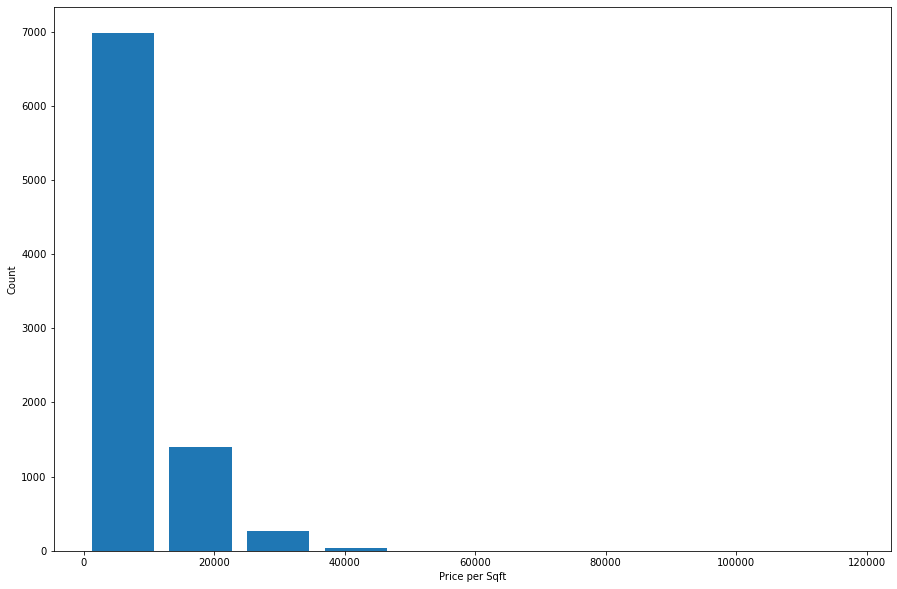

In [32]:
fig, ax = plt.subplots(figsize=(15,10))
plt.hist(property_subset['price_per_sqft'], rwidth=0.8)
plt.xlabel("Price per Sqft")
plt.ylabel("Count")
plt.show()

### Visual Method: Create a Q-Q Plot:
A Q-Q plot compares the quantiles of the data to the quantiles of a theoretical normal distribution. If the points in the plot roughly fall along a straight diagonal line, then the data is assumed to be normally distributed

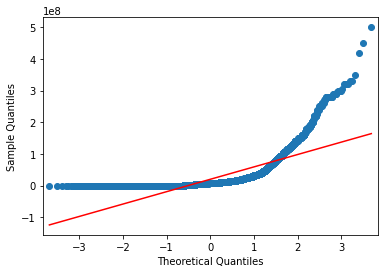

In [33]:
sm.qqplot(property_subset['price'], line='s')
plt.show()

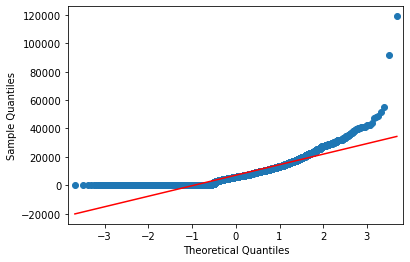

In [34]:
sm.qqplot(property_subset['price_per_sqft'], line='s')
plt.show()

## Outliers detection and removal

We need to remove outliers, considering the above graph as data points aren't normal for total price and price per sqft.

In [35]:
property_subset["location"].nunique()

13

In [36]:
property_subset['location'] = property_subset['location'].apply(lambda x: x.strip())
location_stats = property_subset.groupby('location')['location'].agg('count').sort_values(ascending=False)
location_stats

location
DHA Defence             2949
Gulistan-e-Jauhar       1146
Gulshan-e-Iqbal Town     900
Gadap Town               803
Scheme 33                742
North Karachi            648
North Nazimabad          596
Clifton                  478
Federal B Area           203
Korangi                  188
Naya Nazimabad            24
KDA Scheme 1              18
DHA City Karachi           1
Name: location, dtype: int64

##### i. Each bedroom should have above 300 square feet area

In [37]:
property_subset.drop(property_subset[property_subset['area_sqft'] / property_subset['bedrooms'] < 300].index, inplace = True)

##### ii. Price per sqft needs to be in normal distribution


We need to decrease the standard deviation

In [38]:
property_subset["price_per_sqft"].describe()

count     7982.000000
mean      6799.765831
std       6908.519368
min          0.000765
25%         55.096216
50%       5739.183934
75%      10330.531081
max      55096.216359
Name: price_per_sqft, dtype: float64

In [39]:
# removing price_per_sqft outliers
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key,subdf in df.groupby('location'):
        m = np.mean(subdf['price_per_sqft'])
        std = np.std(subdf['price_per_sqft'])
        reduced_df = subdf[(subdf['price_per_sqft'] > (m-std)) & (subdf['price_per_sqft'] <= (m+std))]
        df_out = pd.concat([df_out,reduced_df], ignore_index=True)
    return df_out

In [40]:
property_subset = remove_pps_outliers(property_subset)
property_subset.shape

(5592, 11)

In [41]:
property_subset["price_per_sqft"].describe()

count     5592.000000
mean      5144.241095
std       4291.166260
min          0.001469
25%         55.096250
50%       5331.879902
75%       8034.894399
max      25252.409309
Name: price_per_sqft, dtype: float64

In [42]:
def plot_scatter_chart(df, location):
    bedroom_2 = df[(df['location'] == location) & (df['bedrooms'] == 2)]
    bedroom_3 = df[(df['location'] == location) & (df['bedrooms'] == 3)]
    matplotlib.rcParams["figure.figsize"] = (15,10)
    plt.scatter(bedroom_2['area_sqft'], bedroom_2['price']/100000, color='blue', label="2 Bedroom", s=50)
    plt.scatter(bedroom_3['area_sqft'], bedroom_3['price']/100000, marker='+', color="green", label="3 Bedroom", s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price")
    plt.title(location)
    plt.legend()

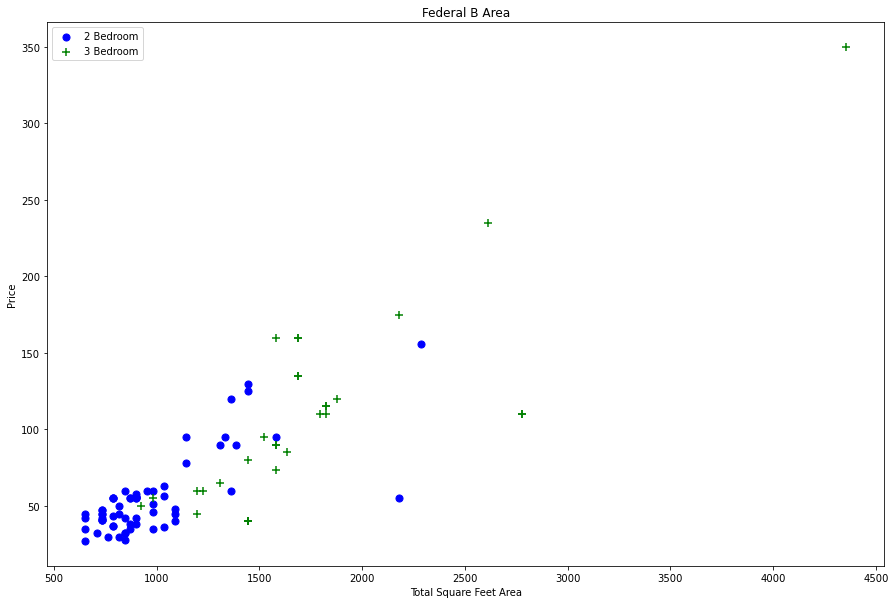

In [43]:
plot_scatter_chart(property_subset, "Federal B Area")

Above graph shows some data points are faulty, the price of 2 bedroom property and 3 bedroom property are located very close such that even the 3 bedroom property price is less than 2 bedroom in the same area.

Removing the outliers for price per square feet such that as the number of bedrooms increase , price per square feet for the property also increases.

In [44]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby("location"):
        bhk_stats = {}
        for bedroom, bedroom_df in location_df.groupby("bedrooms"):
            bhk_stats[bedroom] = {
                'mean' : np.mean(bedroom_df["price_per_sqft"]),
                'std' : np.std(bedroom_df["price_per_sqft"]),
                'count': bedroom_df.shape[0]
            }
        for bedroom, bedroom_df in location_df.groupby("bedrooms"):
            stats = bhk_stats.get(bedroom - 1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bedroom_df[bedroom_df['price_per_sqft'] < (stats['mean'])].index.values)
    return df.drop(exclude_indices, axis="index")

In [45]:
property_subset = remove_bhk_outliers(property_subset)
property_subset.shape

(3274, 11)

In [46]:
property_subset["price_per_sqft"].describe()

count     3274.000000
mean      7841.724318
std       3249.526169
min          4.973963
25%       5739.183934
50%       7433.643797
75%       9907.583371
max      25252.409309
Name: price_per_sqft, dtype: float64

In [47]:
property_subset = property_subset[property_subset["price_per_sqft"] > 3000]

In [48]:
len(property_subset)

3137

In [49]:
property_subset.groupby('location')['location'].agg('count').sort_values(ascending=False)

location
DHA Defence             762
Gulistan-e-Jauhar       456
Scheme 33               427
Gulshan-e-Iqbal Town    368
Gadap Town              345
North Karachi           278
North Nazimabad         264
Federal B Area           91
Clifton                  86
Korangi                  35
Naya Nazimabad           17
KDA Scheme 1              8
Name: location, dtype: int64

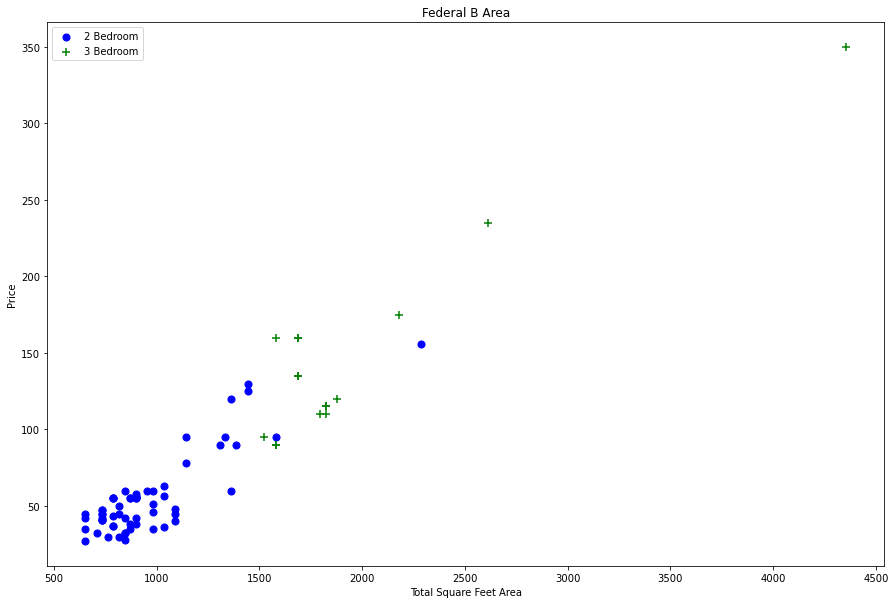

In [50]:
plot_scatter_chart(property_subset,"Federal B Area")

Following graphs show how much impact outlier removal has on the data points! They can't be completely normal but the spread of data points has improved alot!

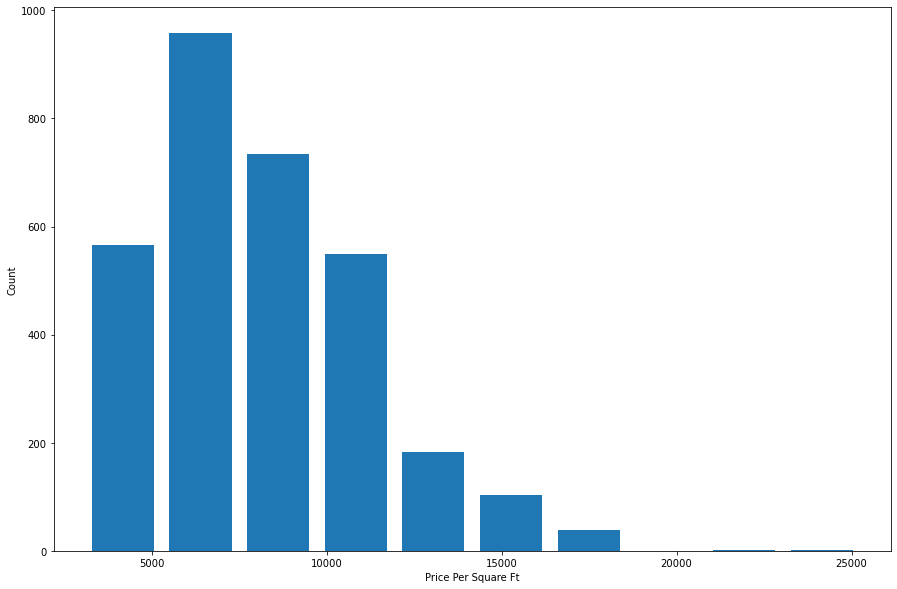

In [51]:
fig, ax = plt.subplots(figsize=(15,10))
plt.hist(property_subset['price_per_sqft'], rwidth=0.8)
plt.xlabel("Price Per Square Ft")
plt.ylabel("Count")
plt.show()

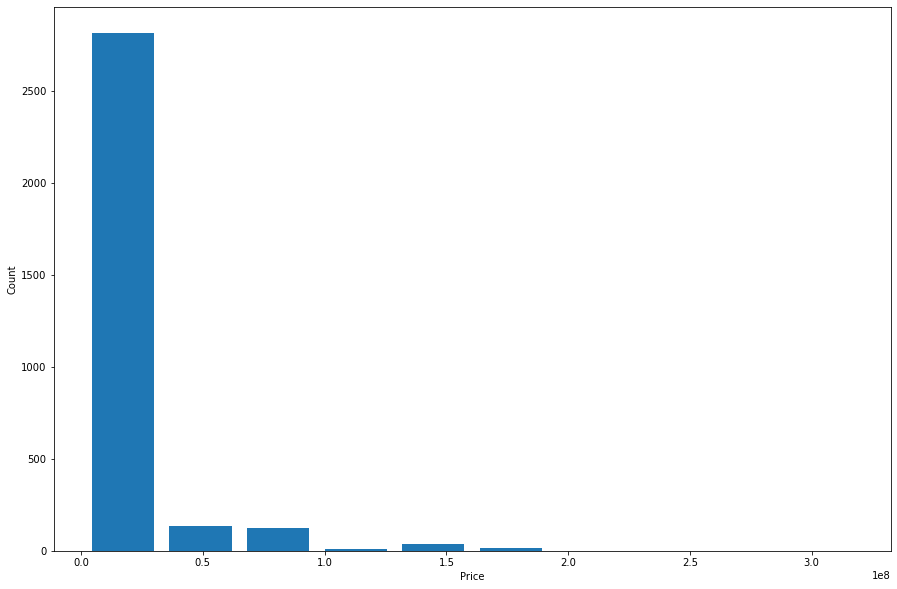

In [52]:
fig, ax = plt.subplots(figsize=(15,10))
plt.hist(property_subset['price'], rwidth=0.8)
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

In [53]:
# now, no need for this column so dropping it
property_subset = property_subset.drop(['price_per_sqft'], axis=1)


In [54]:
# property_data_fe.to_csv('property-data-cleaned.csv', encoding='utf-8')

In [55]:
property_subset.columns

Index(['property_type', 'price', 'price_bin', 'location', 'city', 'baths',
       'area_sqft', 'bedrooms', 'year', 'month'],
      dtype='object')

## Exploratory Data Analysis

### Histogram

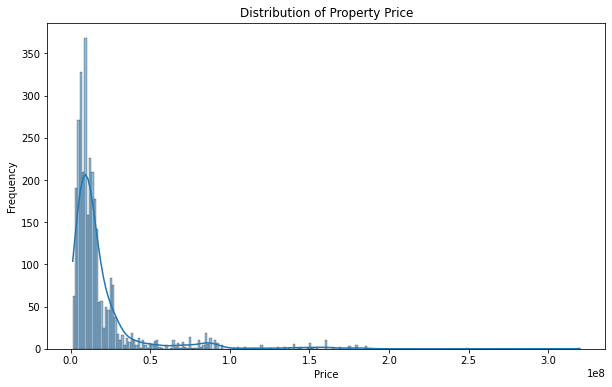

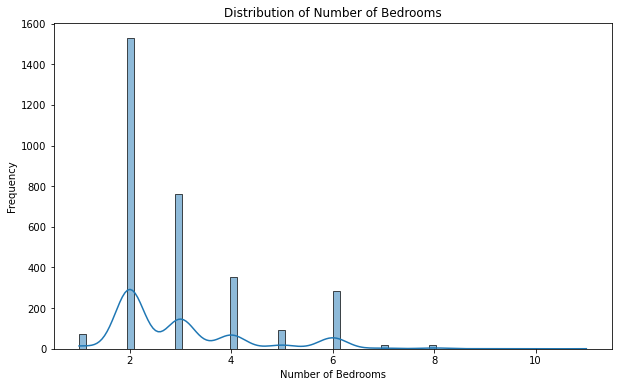

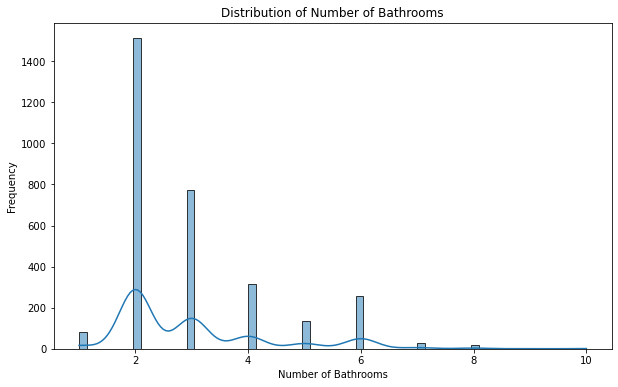

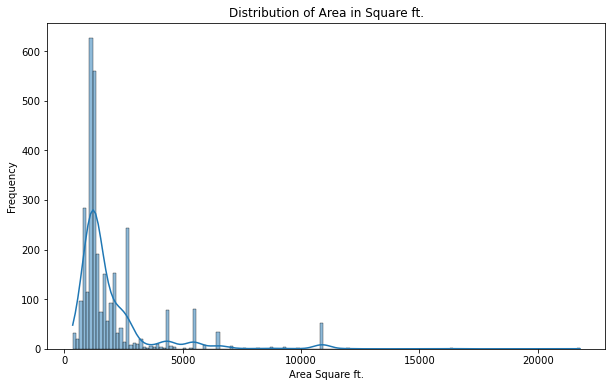

In [56]:
# 1. Histograms and Distribution Plots
# To visualize the distribution of the target variable (property price)
# and numeric features such as the number of bedrooms and bathrooms.
# This helps identify any skewness or outliers in the data.

plt.figure(figsize=(10, 6))
sns.histplot(property_subset['price'], kde=True)
plt.title('Distribution of Property Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(property_subset['bedrooms'], kde=True)
plt.title('Distribution of Number of Bedrooms')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(property_subset['baths'], kde=True)
plt.title('Distribution of Number of Bathrooms')
plt.xlabel('Number of Bathrooms')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(property_subset['area_sqft'], kde=True)
plt.title('Distribution of Area in Square ft.')
plt.xlabel('Area Square ft.')
plt.ylabel('Frequency')
plt.show()

### Scatter Plot

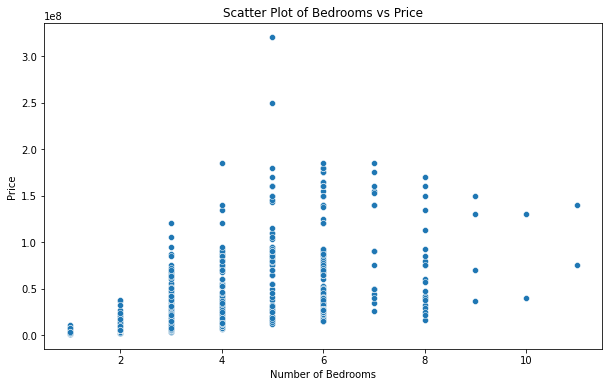

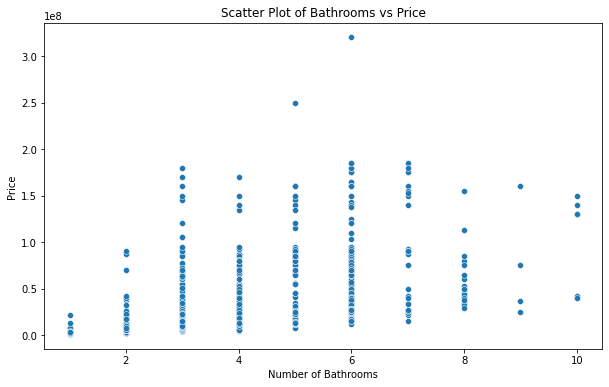

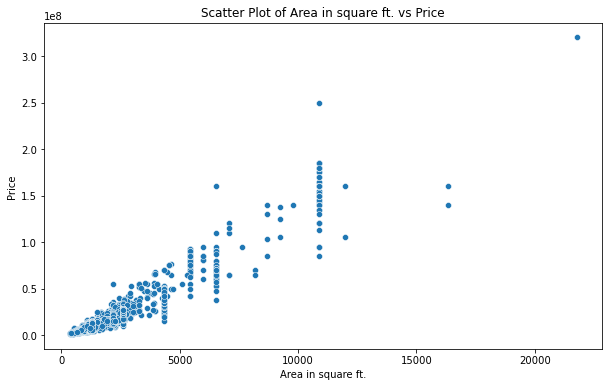

In [57]:
# To visualize the relationship between the numeric features
# (e.g., bedrooms, bathrooms) and the target variable (property price).
# This helps identify any linear or non-linear relationships.


def plot_scatter(x, y, x_label, y_label, title):
  plt.figure(figsize=(10, 6))
  sns.scatterplot(data = property_subset, x = x, y = y)
  plt.title(title)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.show()

plot_scatter(x = "bedrooms", y = "price", x_label = "Number of Bedrooms", y_label = "Price", title = "Scatter Plot of Bedrooms vs Price")

plot_scatter(x = "baths", y = "price", x_label = "Number of Bathrooms", y_label = "Price", title = "Scatter Plot of Bathrooms vs Price")

plot_scatter(x = "area_sqft", y = "price", x_label = "Area in square ft.", y_label = "Price", title = "Scatter Plot of Area in square ft. vs Price")



### Box Plots

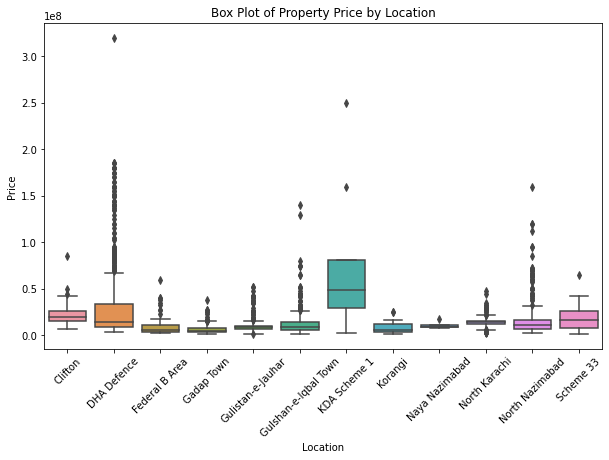

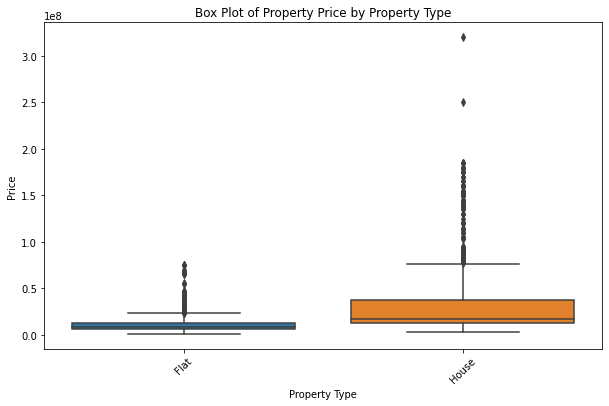

In [58]:
# To visualize the distribution of the target variable for different
# categories of categorical features such as location and property type.
# This helps identify any variations in property prices based on these categories.
plt.figure(figsize=(10, 6))
sns.boxplot(data=property_subset, x='location', y='price')
plt.title('Box Plot of Property Price by Location')
plt.xlabel('Location')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=property_subset, x='property_type', y='price')
plt.title('Box Plot of Property Price by Property Type')
plt.xlabel('Property Type')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()


### Correlation Heatmap

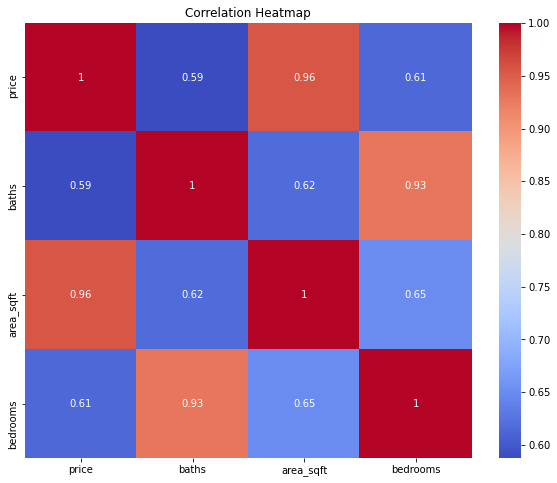

In [59]:
# 4. Correlation Heatmap
# To visualize the pairwise correlations
# between all numeric features and the target variable.
# This helps identify which features have the strongest correlations with the target variable.
plt.figure(figsize=(10, 8))
correlation_matrix = property_subset.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()





### Pair Plot

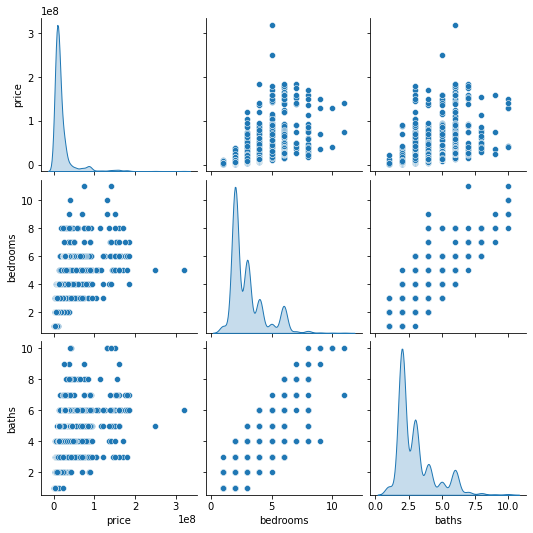

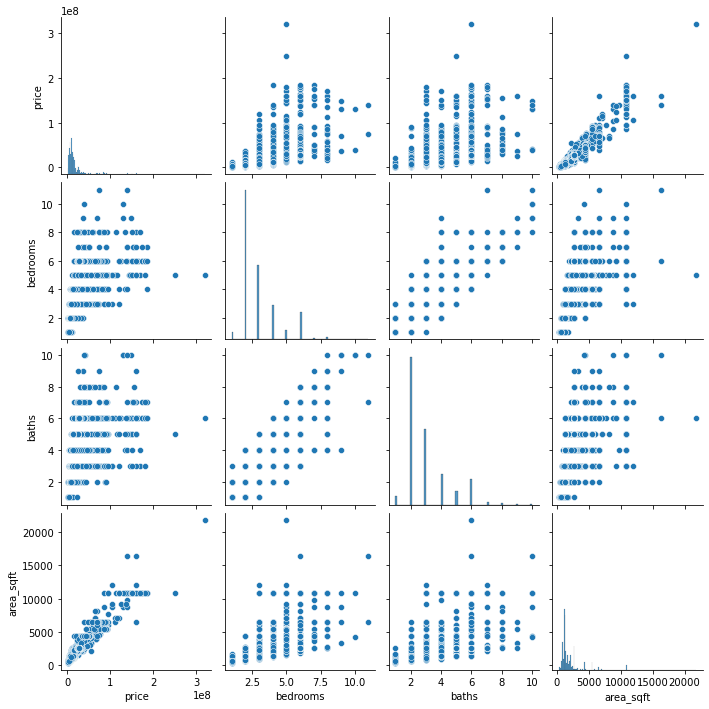

In [60]:
# scatter plots for all pairs of numeric features
# To visualize the relationships among numeric features and the target variable.
# This helps identify potential interactions or non-linear relationships.
sns.pairplot(property_subset[['price', 'bedrooms', 'baths']], diag_kind='kde')
plt.show()

# Pair plot for other numeric features
sns.pairplot(property_subset, vars=['price', 'bedrooms', 'baths', 'area_sqft'])
plt.show()

### Bar Plots

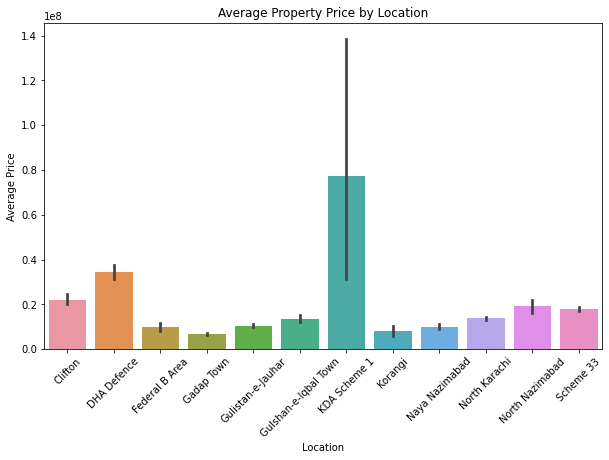

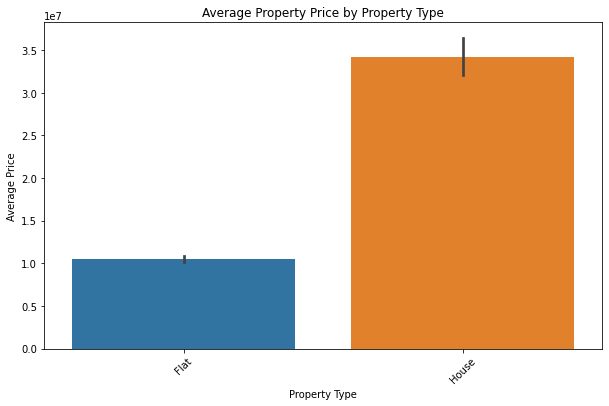

In [61]:
# To visualize the average property prices for different categories of categorical features such as location and property type.
# This helps identify any significant differences in property prices based on these categories.
plt.figure(figsize=(10, 6))
sns.barplot(data=property_subset, x='location', y='price')
plt.title('Average Property Price by Location')
plt.xlabel('Location')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(data=property_subset, x='property_type', y='price')
plt.title('Average Property Price by Property Type')
plt.xlabel('Property Type')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.show()


### Joint Plots

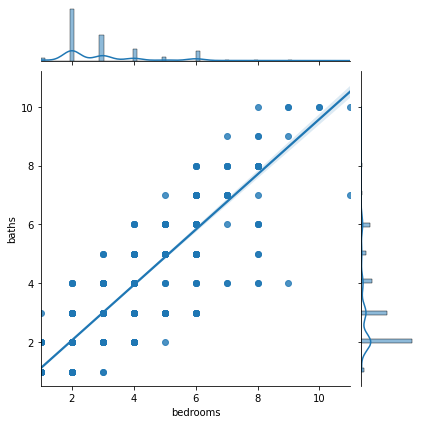

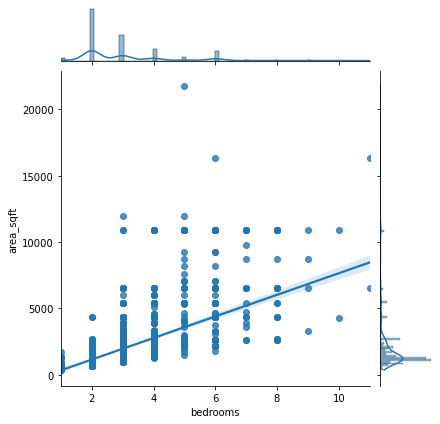

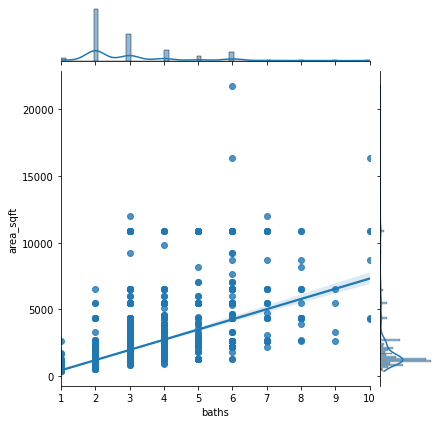

In [62]:
# To visualize the relationship between two numeric features along with the regression line.
# This helps identify the strength and direction of the relationship between pairs of features.

sns.jointplot(data=property_subset, x='bedrooms', y='baths', kind='reg')
plt.show()

sns.jointplot(data=property_subset, x='bedrooms', y='area_sqft', kind='reg')
plt.show()
sns.jointplot(data=property_subset, x='baths', y='area_sqft', kind='reg')
plt.show()

## Preparing the data for model

### i. One-hot encoding the categorical variables

In [63]:
location_dummies = pd.get_dummies(property_subset['location'])
location_dummies.head(3)

,Clifton,DHA Defence,Federal B Area,Gadap Town,Gulistan-e-Jauhar,Gulshan-e-Iqbal Town,KDA Scheme 1,Korangi,Naya Nazimabad,North Karachi,North Nazimabad,Scheme 33
1,1,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0


In [64]:
property_type_dummies = pd.get_dummies(property_subset['property_type'])
property_type_dummies.head(3)

,Flat,House
1,1,0
3,1,0
4,1,0


### ii. Concatenating the one-hot encoded columns with other columns

In [65]:
property_subset = pd.concat([property_subset, property_type_dummies, location_dummies], axis="columns")
property_subset = property_subset.drop(["location", "property_type", "year", "month", "price_bin", "city"], axis=1)
property_subset.head()
property_subset.shape

(3137, 18)

In [66]:
property_subset.head()

,price,baths,area_sqft,bedrooms,Flat,House,Clifton,DHA Defence,Federal B Area,Gadap Town,Gulistan-e-Jauhar,Gulshan-e-Iqbal Town,KDA Scheme 1,Korangi,Naya Nazimabad,North Karachi,North Nazimabad,Scheme 33
1,26000000,3,2232.46,3,1,0,1,0,0,0,0,0,0,0,0,0,0,0
3,17000000,3,1742.41,3,1,0,1,0,0,0,0,0,0,0,0,0,0,0
4,13500000,3,1987.43,3,1,0,1,0,0,0,0,0,0,0,0,0,0,0
6,29000000,3,3620.94,3,1,0,1,0,0,0,0,0,0,0,0,0,0,0
7,15000000,3,1824.08,3,1,0,1,0,0,0,0,0,0,0,0,0,0,0


In [67]:
property_subset.columns

Index(['price', 'baths', 'area_sqft', 'bedrooms', 'Flat', 'House', 'Clifton',
       'DHA Defence', 'Federal B Area', 'Gadap Town', 'Gulistan-e-Jauhar',
       'Gulshan-e-Iqbal Town', 'KDA Scheme 1', 'Korangi', 'Naya Nazimabad',
       'North Karachi', 'North Nazimabad', 'Scheme 33'],
      dtype='object')

### iii. Assigning descriptor columns

In [68]:
# all columns except these that are dropped
X = property_subset.drop(['price'], axis=1)
X.head()

,baths,area_sqft,bedrooms,Flat,House,Clifton,DHA Defence,Federal B Area,Gadap Town,Gulistan-e-Jauhar,Gulshan-e-Iqbal Town,KDA Scheme 1,Korangi,Naya Nazimabad,North Karachi,North Nazimabad,Scheme 33
1,3,2232.46,3,1,0,1,0,0,0,0,0,0,0,0,0,0,0
3,3,1742.41,3,1,0,1,0,0,0,0,0,0,0,0,0,0,0
4,3,1987.43,3,1,0,1,0,0,0,0,0,0,0,0,0,0,0
6,3,3620.94,3,1,0,1,0,0,0,0,0,0,0,0,0,0,0
7,3,1824.08,3,1,0,1,0,0,0,0,0,0,0,0,0,0,0


In [69]:
X.shape

(3137, 17)

### iv. Assigning predictor column i.e., price

In [70]:
y = property_subset['price']
y.head()

1    26000000
3    17000000
4    13500000
6    29000000
7    15000000
Name: price, dtype: int64

## Applying Regression

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.9457004618099261

Checking results on cross-validated data

In [72]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.92722621, 0.93304882, 0.92002214, 0.93384027, 0.92944438])

### Searching for best Regression model using GridSearch

In [73]:
def find_best_model_using_gridsearchcv(X, y):
    algos = {
        'linear_regression': {
            'model':LinearRegression(),
            'params': {'positive': [False]}

        },'decision_tree_regressor':{
            'model': DecisionTreeRegressor(),
            'params': {'criterion': ['mse','friedman_mse'], 'splitter':['best','random']}
        },'lasso': {
            'model':Lasso(),
            'params': {'alpha':[1,2], 'selection':['random','cyclic']}
        }
    }


    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    scores = []
    for algo_name, config in algos.items():
        gs = GridSearchCV(config['model'], config['params'], return_train_score=False, n_jobs=-1, cv=cv)
        gs.fit(X, y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_ ,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores, columns=['model','best_score','best_params'])

In [74]:
find_best_model_using_gridsearchcv(X, y)

c:\Users\CC\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\CC\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\CC\anaconda3\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\CC\anaconda3\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\CC\anaconda3\lib\site-packages\sklearn\utils\_p

,model,best_score,best_params
0,linear_regression,0.928716,{'positive': False}
1,decision_tree_regressor,0.941156,"{'criterion': 'friedman_mse', 'splitter': 'ran..."
2,lasso,0.928716,"{'alpha': 2, 'selection': 'random'}"


### Utilizing the best Regression model

Decision Tree Regression model performs the best, so we'll be using it along with the specified best parameters for training the data and predicting property price.

In [75]:
dtr = DecisionTreeRegressor(criterion='squared_error', splitter='random', random_state=0)
dtr.fit(X, y)

DecisionTreeRegressor(random_state=0, splitter='random')

### Predicting the price on the basis of selected descriptors

In [76]:
def predict_price(location, sqft, bedrooms, baths, property_type):
    loc_index = np.where(X.columns==location)[0][0]
    property_type = np.where(X.columns==property_type)[0][0]



    x = np.zeros(len(X.columns))
    x[0] = baths
    x[1] = sqft
    x[2] = bedrooms
    if loc_index >= 0:
        x[loc_index] = 1
    if property_type >= 0:
        x[property_type] = 1



    return dtr.predict([x])[0] / 100000

In [77]:
print(str(int(predict_price('North Nazimabad', 1900, 4, 3, 'Flat'))) + " Lacs")

153 Lacs


c:\Users\CC\anaconda3\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


## Creating Neural Network

In [78]:
model = Sequential()

# input layer
model.add(Dense(128,activation='relu', input_shape = (17,)))

# hidden layers
model.add(Dense(256,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(256,activation='relu'))


# output layer
model.add(Dense(1))

model.compile(optimizer='rmsprop',loss='mse')


### Training the model

In [79]:
model.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=128,epochs=450)

Epoch 1/450
20/20 [==============================] - 2s 32ms/step - loss: 1015490927394816.0000 - val_loss: 890813865263104.0000
Epoch 2/450
20/20 [==============================] - 0s 11ms/step - loss: 696608463257600.0000 - val_loss: 301962843127808.0000
Epoch 3/450
20/20 [==============================] - 0s 10ms/step - loss: 152532626178048.0000 - val_loss: 78169897959424.0000
Epoch 4/450
20/20 [==============================] - 0s 10ms/step - loss: 93175792271360.0000 - val_loss: 77913097502720.0000
Epoch 5/450
20/20 [==============================] - 0s 12ms/step - loss: 98856045903872.0000 - val_loss: 78560924532736.0000
Epoch 6/450
20/20 [==============================] - 0s 10ms/step - loss: 95277113409536.0000 - val_loss: 80006986334208.0000
Epoch 7/450
20/20 [==============================] - 0s 10ms/step - loss: 95452787638272.0000 - val_loss: 78070979493888.0000
Epoch 8/450
20/20 [==============================] - 0s 10ms/step - loss: 95555120267264.0000 - val_loss: 777897

### Visualizing training loss

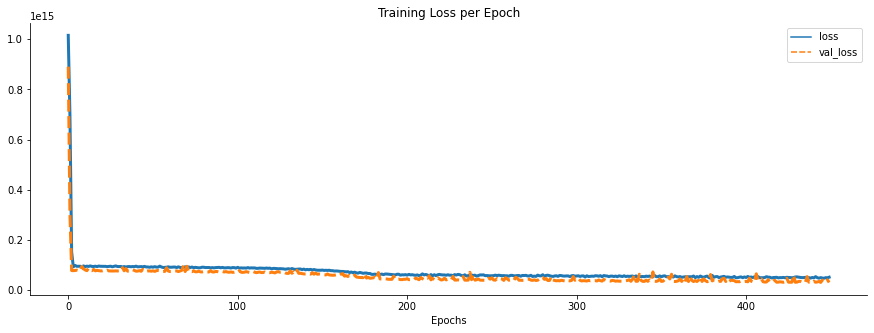

In [80]:
losses = pd.DataFrame(model.history.history)

plt.figure(figsize=(15,5))
sns.lineplot(data=losses,lw=3)
plt.xlabel('Epochs')
plt.ylabel('')
plt.title('Training Loss per Epoch')
sns.despine()

# model doesn't overfit

### Predicting prices

In [81]:
# predictions on the test set
predictions = model.predict(X_test)

print('MAE: ',mean_absolute_error(y_test,predictions))
print('MSE: ',mean_squared_error(y_test,predictions))
print('RMSE: ',np.sqrt(mean_squared_error(y_test,predictions)))
print('Variance Regression Score: ',explained_variance_score(y_test,predictions))

print('\n\nDescriptive Statistics:\n',property_data_fe['price'].describe())

20/20 [==============================] - 0s 3ms/step
MAE:  3218288.7628383758
MSE:  30987240907028.266
RMSE:  5566618.444534192
Variance Regression Score:  0.9511501395928271


Descriptive Statistics:
 count    2.423400e+04
mean     2.414683e+07
std      4.620637e+07
min      1.000000e+00
25%      2.500000e+06
50%      9.000000e+06
75%      2.300000e+07
max      1.450000e+09
Name: price, dtype: float64


### Residual Plot

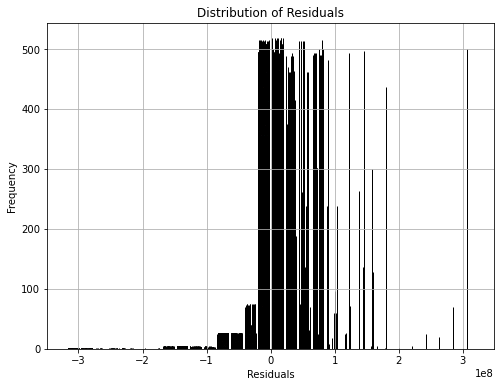

In [82]:
y_test = y_test.to_numpy()
actual_prices = y_test
predicted_prices = predictions

# Calculate residuals
residuals = actual_prices - predicted_prices

# Plotting the residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, edgecolor='k')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

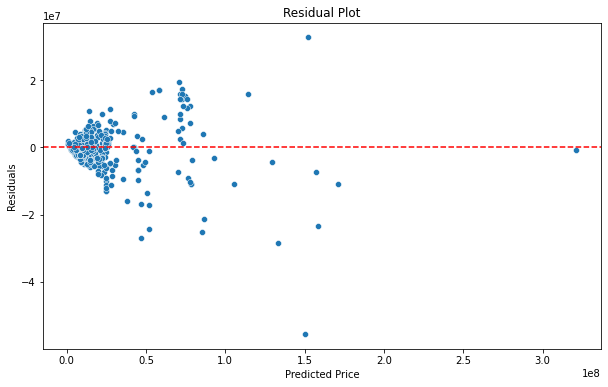

In [83]:
# Flatten predictions to convert it into a 1-dimensional array
predictions = predictions.flatten()

# Compute residuals
residuals = actual_prices - predictions
# Plot the residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(x=predictions, y=residuals)
plt.title('Residual Plot')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

## Saving Model in h5 and tflite formats

In [84]:
# save model and architecture to single file
model.save(os.path.join(model_path, "model.h5"))
print("Saved model to disk")

Saved model to disk


c:\Users\CC\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [86]:
loaded_model = tf.keras.models.load_model(os.path.join(model_path, "model.h5"))
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
tflite_model = converter.convert()
with open(os.path.join(model_path, "trainer_model.tflite"), "wb") as f:
    f.write(tflite_model)

print("TFLite model saved successfully.")

INFO:tensorflow:Assets written to: C:\Users\CC\AppData\Local\Temp\tmpmmq4s4kp\assets


INFO:tensorflow:Assets written to: C:\Users\CC\AppData\Local\Temp\tmpmmq4s4kp\assets


TFLite model saved successfully.
